In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import arviz as az
import jax
import jax.numpy as jnp
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel

class MixedEffects(BaseModel):
    Name = "mixed_effects_injury_threshold_comparison"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, l, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -l + jnp.true_divide(
                    H + l,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + l, l),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None, **kwargs):
        if response_obs is not None: response_obs = response_obs.flatten(order="F")

        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]
        n_baseline = 1

        

        """ Fixed Effect (Baseline) """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                a_mean_baseline = numpyro.sample("a_mean_baseline", dist.HalfNormal(scale=50))

        """ Random Effect (Delta) """
        a_mean_delta_global_loc = numpyro.sample("a_mean_delta_global_loc", dist.Normal(loc=0, scale=100))
        a_mean_delta_global_scale = numpyro.sample("a_mean_delta_global_scale", dist.HalfNormal(100))
        a_mean_delta_global_df_minus_one = numpyro.sample("a_mean_delta_global_df_minus_one", dist.Exponential(1 / 29.))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", (n_feature0 - n_baseline), dim=-2):
                a_mean_delta = numpyro.sample(
                    "a_mean_delta",
                    dist.StudentT(
                        loc=a_mean_delta_global_loc,
                        scale=a_mean_delta_global_scale,
                        df=a_mean_delta_global_df_minus_one + 1
                    )
                )

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
            l_scale_global_scale = numpyro.sample("l_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            a_shape = numpyro.sample("a_shape", dist.HalfNormal(scale=100))

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                a_mean = numpyro.deterministic(
                    "a_mean",
                    jnp.concatenate([a_mean_baseline, a_mean_baseline + a_mean_delta], axis=0)
                )

                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                l_scale_raw = numpyro.sample("l_scale_raw", dist.HalfNormal(scale=1))
                l_scale = numpyro.deterministic("sigma_l", jnp.multiply(l_scale_global_scale, l_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    with numpyro.handlers.mask(mask=mask):
                        """ Priors """
                        a_raw = numpyro.sample("a_raw", dist.Gamma(concentration=a_shape, rate=1))
                        a = numpyro.deterministic(site.a, jnp.true_divide(jnp.multiply(a_raw, a_mean), a_shape))

                        b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                        b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                        v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                        v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                        L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                        L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                        l_raw = numpyro.sample("l_raw", dist.HalfNormal(scale=1))
                        l = numpyro.deterministic("l", jnp.multiply(l_scale, l_raw))

                        H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                        H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                        g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                        g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                        g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                        g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Penalty """
        a_mean_penalty_for_negative = (jnp.fabs(a_mean_baseline + a_mean_delta) - (a_mean_baseline + a_mean_delta))
        numpyro.factor("a_mean_penalty_for_negative", -a_mean_penalty_for_negative)

        a_penalty_for_negative = (jnp.fabs(a) - a)
        numpyro.factor("a_penalty_for_negative", -a_penalty_for_negative)

        """ Outlier Distribution """
        outlier_dist_shape = numpyro.sample("outlier_dist_loc", dist.HalfNormal(5))
        outlier_dist_rate = numpyro.sample("outlier_dist_scale", dist.HalfNormal(1))

        """ Mixture """
        if response_obs is not None:
            outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0.0, 0.1))
        else: # Turn off mixture when predicting
            outlier_prob = numpyro.deterministic("outlier_prob", 0.)

        mixing_distribution = dist.Categorical(probs=jnp.array([1 - outlier_prob, outlier_prob]))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        l=l[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

        """ Mixture """
        component_distributions = [
            dist.Gamma(concentration=jnp.multiply(mu.flatten(order="F"), beta.flatten(order="F")), rate=beta.flatten(order="F")),
            dist.Gamma(concentration=outlier_dist_shape, rate=outlier_dist_rate)
        ]
        Mixture = dist.MixtureGeneral(
            mixing_distribution=mixing_distribution,
            component_distributions=component_distributions
        )

        with numpyro.plate("obs_plate", n_data * self.n_response):
            """ Observation """
            _obs = numpyro.sample(
                "_obs",
                Mixture,
                obs=response_obs
            )

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_data, n_data, dim=-2):
                numpyro.deterministic(
                    site.obs,
                    _obs.reshape(self.n_response, -1).T
                )


In [ ]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/injury-threshold-comparison/long.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "fixed-outside-separated")

config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000

model = MixedEffects(config=config)


2023-11-13 14:18:40,228 - hbmep.config - INFO - Verifying configuration ...
2023-11-13 14:18:40,228 - hbmep.config - INFO - Success!
2023-11-13 14:18:40,249 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc_proc-2023-10-27.csv"
data = pd.read_csv(src)

data[model.features[0]] = \
    data[model.features[0]].replace({
        "Uninjured": "01_Uninjured",
        "SCI": "02_SCI"
    })

df, encoder_dict = model.load(df=data)


2023-11-13 14:18:40,367 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/injury-threshold-comparison/long/fixed-outside-masked
2023-11-13 14:18:40,368 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/injury-threshold-comparison/long/fixed-outside-masked
2023-11-13 14:18:40,369 - hbmep.dataset.core - INFO - Processing data ...
2023-11-13 14:18:40,371 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-13 14:18:40,790 - hbmep.model.baseline - INFO - Running inference with base_model ...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [7]:
prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-13 14:05:10,212 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


2023-11-13 14:05:20,624 - hbmep.utils.utils - INFO - func:predict took: 10.41 sec
2023-11-13 14:05:20,626 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-11-13 14:05:27,168 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/injury-threshold-comparison/long/fixed-outside/recruitment_curves.pdf
2023-11-13 14:05:27,168 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 6.54 sec
2023-11-13 14:05:27,169 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-11-13 14:05:33,664 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/injury-threshold-comparison/long/fixed-outside/posterior_predictive_check.pdf
2023-11-13 14:05:33,664 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 6.49 sec
2023-11-13 14:05:33,664 - hbmep.utils.utils - INFO - func:render_predictive_check took: 6.50 sec


Text(0.5, 1.0, '$\\Pr($ SCI Threshold > Uninjured Threshold $)$ = 0.989')

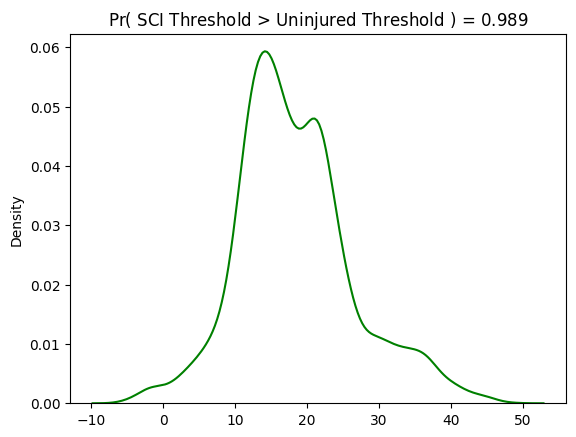

In [17]:
muscle_ind = 0

a_mean_delta = posterior_samples["a_mean_delta"]
a_mean_delta = np.array(a_mean_delta)

sns.kdeplot(a_mean_delta[:, 0, muscle_ind], color="green", label="Posterior")
plt.title(f"$\Pr($ SCI Threshold > Uninjured Threshold $)$ = {(a_mean_delta[:, 0, muscle_ind] > 0).mean():.3f}")


Text(0.5, 1.0, '$\\Pr($ SCI Threshold > Uninjured Threshold $)$ = 0.998')

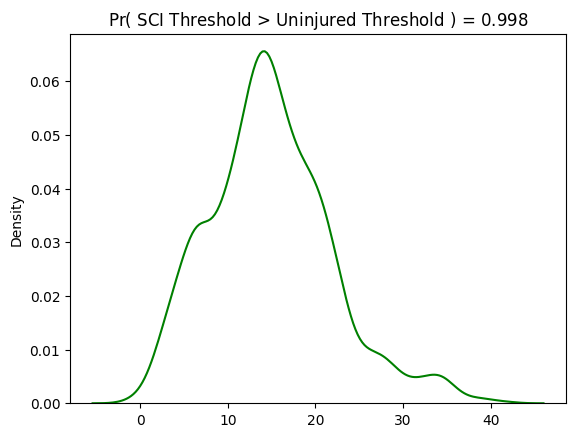

In [16]:
muscle_ind = 1

a_mean_delta = posterior_samples["a_mean_delta"]
a_mean_delta = np.array(a_mean_delta)

sns.kdeplot(a_mean_delta[:, 0, muscle_ind], color="green", label="Posterior")
plt.title(f"$\Pr($ SCI Threshold > Uninjured Threshold $)$ = {(a_mean_delta[:, 0, muscle_ind] > 0).mean():.3f}")


In [19]:
a_mean = posterior_samples["a_mean"]
a_mean = np.array(a_mean)
a_mean.shape

a = posterior_samples["a"]
a = np.array(a)
a.shape

(4000, 16, 2, 2)

In [25]:
a[:, :10, 0, :].mean(axis=(0, 1))

array([40.27554888, 40.69555083])

In [26]:
a_mean[:, 0, :].mean(axis=0)

array([43.5754812 , 40.41782577])

In [27]:
a[:, 10:, 1, :].mean(axis=(0, 1))


array([56.65183156, 55.62198015])

In [29]:
a[:, :, 1, :].mean(axis=(0, 1))


array([59.59333437, 55.25737417])

In [28]:
a_mean[:, 1, :].mean(axis=0)


array([61.93289189, 55.32786217])